Project Strategy:

Use MPO area. 

"Best zip code for young families to live in that care about having ample outdoor recreation options"

Six Indicators:
1. Farmers Markets (provided data) - Euclidean Distance
2. Tree Canopy Raster (provided data) 
3. Bike trails (outside, from MassGIS) - Euclidean Distance
4. Public pools (outside, from MassGIS) - Euclidean Distance
5. Blue bikes (outside, from BlueBikes) - Euclidean Distance
6. (Time allowing) Maybe download data on coffee shops? Reference USA - Euclidean Distance

In [45]:
import pandas as pd
import geopandas as gpd

import rasterio
from rasterio.plot import show
from rasterio import features

from scipy import ndimage

In [2]:
#bring in MPO boundary file

mpo_boundaries = gpd.read_file('Data/MPO_Boundary/MPO_Boundaries/MPO_Boundaries.shp')
mpo_boundaries

,OBJECTID,MPO,created_us,created_da,last_edite,last_edi_1,GlobalID,ShapeSTAre,ShapeSTLen,geometry
0,2,Berkshire,None,1970-01-01,None,1970-01-01,{08FDA544-18B0-412A-B442-287E53E987F7},2.451015e+09,2.471530e+05,"POLYGON ((-8128884.676 5272654.345, -8128962.2..."
1,3,Cape Cod,None,1970-01-01,None,1970-01-01,{B6CD90CF-2F7D-43F2-B251-FA7F8E00EF01},1.067067e+09,1.288227e+06,"MULTIPOLYGON (((-7813968.781 5173329.197, -781..."
2,4,Central Massachusetts,None,1970-01-01,None,1970-01-01,{CC777E14-53C8-42AD-B421-71444DA0BB60},2.487546e+09,2.683265e+05,"POLYGON ((-7977225.352 5223837.273, -7973861.8..."
3,5,Franklin,None,1970-01-01,None,1970-01-01,{4804E708-6B89-4A85-9383-BD91F7589981},1.876456e+09,2.527017e+05,"POLYGON ((-8046511.241 5269691.856, -8045276.8..."
4,6,Montachusett,None,1970-01-01,None,1970-01-01,{F315DA63-C9CF-40EE-8AA7-5ABA2E1FD528},1.772355e+09,2.748684e+05,"POLYGON ((-7976246.504 5267152.001, -7976121.9..."
5,7,Martha's Vineyard,None,1970-01-01,None,1970-01-01,{84077DC9-D5D1-471D-9A64-1E5748F80B92},2.757449e+08,3.701721e+05,"MULTIPOLYGON (((-7859473.886 5083806.270, -785..."
6,8,Merrimack Valley,None,1970-01-01,None,1970-01-01,{C09CD5BA-4FE1-45DD-838E-19F2ECF618DB},7.188680e+08,3.847121e+05,"MULTIPOLYGON (((-7890949.271 5294156.354, -788..."
7,9,Northern Middlesex,None,1970-01-01,None,1970-01-01,{5B2D231C-F8EB-4768-AB7F-F9D02B3EDBBD},5.073539e+08,1.410283e+05,"POLYGON ((-7922038.111 5250986.670, -7923186.5..."
8,10,Nantucket,None,1970-01-01,None,1970-01-01,{633A0B7F-266B-4F07-AA30-EC320231ADAA},1.266795e+08,1.680333e+05,"MULTIPOLYGON (((-7797087.819 5069759.518, -779..."
9,11,Pioneer Valley,None,1970-01-01,None,1970-01-01,{B01F3417-DC74-4561-AE49-935ACC6EF1FF},3.054352e+09,3.206858e+05,"POLYGON ((-8049986.018 5212603.033, -8049953.4..."


In [3]:
#select just Boston Region MPO
#reproject to epsg=6491

boston_mpo_area = mpo_boundaries[mpo_boundaries['MPO']=='Boston Region'].copy()
boston_mpo_area.to_crs('epsg:6491', inplace=True)

<AxesSubplot:>

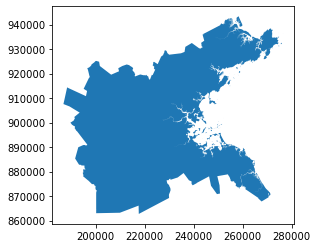

In [4]:
boston_mpo_area.plot()

In [5]:
boston_mpo_area.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
#bring in zcta shapefile
#reproject to epsg=6491

zcta = gpd.read_file('Data/ZCTA_boundary/tl_2010_25_zcta510/tl_2010_25_zcta510.shp')
zcta.to_crs('epsg:6491', inplace=True)

<AxesSubplot:>

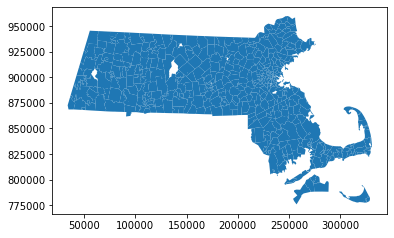

In [7]:
zcta.plot()

In [8]:
zcta.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,25,02536,2502536,B5,G6350,S,71696166,9066635,+41.5969756,-070.5678768,N,"POLYGON ((275712.154 812608.480, 275688.314 81..."
1,25,02556,2502556,B5,G6350,S,10034104,1164445,+41.6394454,-070.6245149,N,"POLYGON ((273020.046 818874.990, 272816.173 81..."
2,25,02540,2502540,B5,G6350,S,27746696,4550024,+41.5741900,-070.6282848,N,"POLYGON ((273020.046 818874.990, 273126.263 81..."
3,25,02646,2502646,B5,G6350,S,7798581,801405,+41.6705961,-070.0714493,N,"POLYGON ((318297.748 826255.912, 318348.040 82..."
4,25,01237,2501237,B5,G6350,S,160121626,1140685,+42.5478177,-073.2680327,N,"POLYGON ((57335.091 917317.398, 57310.861 9173..."


In [9]:
zcta.crs

<Projected CRS: EPSG:6491>
Name: NAD83(2011) / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [10]:
zcta.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,25,02536,2502536,B5,G6350,S,71696166,9066635,+41.5969756,-070.5678768,N,"POLYGON ((275712.154 812608.480, 275688.314 81..."
1,25,02556,2502556,B5,G6350,S,10034104,1164445,+41.6394454,-070.6245149,N,"POLYGON ((273020.046 818874.990, 272816.173 81..."
2,25,02540,2502540,B5,G6350,S,27746696,4550024,+41.5741900,-070.6282848,N,"POLYGON ((273020.046 818874.990, 273126.263 81..."
3,25,02646,2502646,B5,G6350,S,7798581,801405,+41.6705961,-070.0714493,N,"POLYGON ((318297.748 826255.912, 318348.040 82..."
4,25,01237,2501237,B5,G6350,S,160121626,1140685,+42.5478177,-073.2680327,N,"POLYGON ((57335.091 917317.398, 57310.861 9173..."


In [11]:
#clip to get zip code poloygons for just Boston MPO

boston_zips = gpd.clip(zcta, boston_mpo_area)
boston_zips



,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
17,25,01905,2501905,B5,G6350,S,9219345,1195154,+42.4659985,-070.9757922,N,"MULTIPOLYGON (((243877.753 913824.638, 243872...."
18,25,01904,2501904,B5,G6350,S,11708211,1303900,+42.4924563,-070.9739297,N,"POLYGON ((245700.484 914778.700, 245667.412 91..."
20,25,01930,2501930,B5,G6350,S,67847425,13972397,+42.6199100,-070.6818235,N,"MULTIPOLYGON (((261745.067 931625.267, 261822...."
21,25,01915,2501915,B5,G6350,S,39091336,3958118,+42.5702688,-070.8669962,N,"MULTIPOLYGON (((250787.714 926889.372, 251155...."
22,25,01921,2501921,B5,G6350,S,61010486,2188501,+42.6831083,-071.0183302,N,"MULTIPOLYGON (((245193.985 936821.773, 244097...."
...,...,...,...,...,...,...,...,...,...,...,...,...
526,25,02129,2502129,B5,G6350,S,3492181,1266666,+42.3796570,-071.0614875,N,"MULTIPOLYGON (((235381.204 902518.358, 235374...."
527,25,02128,2502128,B5,G6350,S,12561059,2952872,+42.3611289,-071.0069754,N,"MULTIPOLYGON (((240184.037 905141.775, 240204...."
528,25,02122,2502122,B5,G6350,S,5263269,1641767,+42.2914125,-071.0421575,N,"MULTIPOLYGON (((237311.389 892366.860, 237300...."
529,25,02151,2502151,B5,G6350,S,15190546,3291332,+42.4182938,-071.0012566,N,"MULTIPOLYGON (((240204.477 905138.116, 240184...."


<AxesSubplot:>

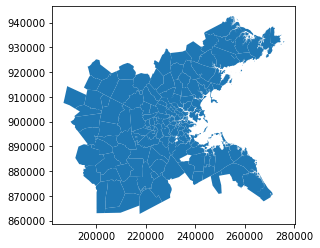

In [12]:
boston_zips.plot()

In [42]:
#read in the tree canopy raster

with rasterio.open('Data/Tree_canopy/NLCD_2016_Tree_Canopy_Boston.tif') as tree:
    shape_tree = tree.shape
    transform_tree = tree.transform
    res_tree = tree.res
    crs_tree = tree.crs
    nodata_tree = tree.nodata
    bounds_tree = tree.bounds
    tree_canopy = tree.read(1)

In [44]:
#count number of bands

tree.count

1

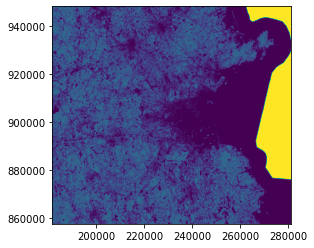

<AxesSubplot:>

In [43]:
#visualize the tree canopy raster

show(tree_canopy, transform=transform_tree)

In [56]:
#read in farmers markets points

markets = gpd.read_file('Data/Farmers_Markets/FARMERSMARKETS_PT/FARMERSMARKETS_PT.shp')

In [57]:
markets.head()

,MARKET_ID,NAME,TYPE,ADDR_1,ADDR_2,TOWN,ZIP_CODE,DAY_TIME,DATES,UPDATE_DAT,YEAR_START,WEBSITE,EBT,WIC_CVV,COUPONS,LONGITUDE,LATITUDE,geometry
0,606.0,Sustainable Nantucket/Wednesday,Farmers Markets,113 Pleasant St.,Next to Glidden's Seafood,Nantucket,02554,"Wednesday, 3:30 pm - 6:30 pm",July 6 to September 14,2016,2016,http://www.sustainablenantucket.org,EBT-SNAP Accepted,None,WIC & Senior Coupons Accepted,-70.09361,41.27301,POINT (317843.084 781295.223)
1,607.0,Holden/Market on Main at Jed's,Farmers Markets,450 Main St.,Jed's Hardware and Garden,Holden,01520,"Friday, 3:30 pm - 7:00 pm",May 20 to October 28,2016,2016,None,None,None,None,-71.83454,42.33213,POINT (172428.679 898013.943)
2,535.0,West Newton,Farmers Markets,Elm Street,off Washington Street,West Newton,02465,"Saturday, 10:00 am - 2:00 pm",June 18 to October 8,2016,2014,http://www.newtonma.gov/gov/parks,EBT-SNAP Accepted,None,WIC & Senior Coupons Accepted,-71.22932,42.34906,POINT (222302.311 899875.783)
3,538.0,Plainville,Farmers Markets,200 South Street,Old Wood School,Plainville,02762,"Sunday, 10:00 am - 2:00 pm",May 25 to November 2,2015,2014,http://www.plainvillefarmersmarket.com/,EBT-SNAP Accepted,None,WIC & Senior Coupons Accepted,-71.33843,42.00941,POINT (213383.817 862127.128)
4,539.0,Worcester Art Museum,Farmers Markets,Lancaster St.,Worcester Art Museum,Worcester,01609,"Saturdays, 10:00 am - 1:00 pm",July 11 to August 29,2015,2014,None,None,None,WIC & Senior Coupons Accepted,-71.80202,42.27328,POINT (175085.678 891467.195)


<AxesSubplot:>

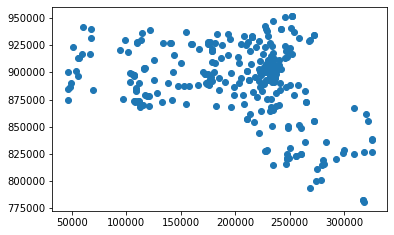

In [58]:
markets.plot()

In [59]:
#create binary raster

market_raster = features.rasterize(markets['geometry'], out_shape=shape_tree, fill=1, transform=transform_tree, default_value=0)

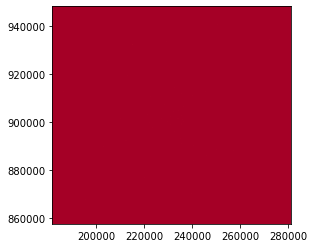

<AxesSubplot:>

In [62]:
show(market_raster, transform=transform_tree, cmap='RdYlBu_r')

In [63]:
#calculate euclidean distance

market_distance = ndimage.distance_transform_edt(market_raster)

In [64]:
market_distance

array([[445.53899942, 445.45706864, 445.37736808, ..., 547.84760655,
        548.38854839, 548.93077888],
       [444.54246141, 444.46034694, 444.38046762, ..., 547.0063985 ,
        547.5481714 , 548.09123328],
       [443.545939  , 443.46364   , 443.38358111, ..., 546.16572576,
        546.70833175, 547.25222704],
       ...,
       [379.42719987, 379.38107491, 379.33758053, ..., 738.46597755,
        739.21918265, 739.97297248],
       [380.42607692, 380.38007308, 380.33669294, ..., 739.12448207,
        739.87701681, 740.63013711],
       [381.42495985, 381.37907651, 381.33581002, ..., 739.78375219,
        740.53561697, 741.28806816]])

In [65]:
res_tree[0]

30.0

In [66]:
#multiply by cell size using the res attribute

market_distance = ndimage.distance_transform_edt(market_raster) * res_tree[0]

In [67]:
market_distance

array([[13366.16998246, 13363.71205915, 13361.32104247, ...,
        16435.42819643, 16451.65645156, 16467.92336635],
       [13336.27384242, 13333.81040813, 13331.41402853, ...,
        16410.191955  , 16426.4451419 , 16442.73699844],
       [13306.37816989, 13303.90919993, 13301.50743337, ...,
        16384.97177294, 16401.24995237, 16417.56681119],
       ...,
       [11382.81599605, 11381.43224731, 11380.12741581, ...,
        22153.97932652, 22176.57547955, 22199.18917438],
       [11412.78230757, 11411.40219254, 11410.10078834, ...,
        22173.7344622 , 22196.31050423, 22218.90411339],
       [11442.74879563, 11441.37229531, 11440.07430046, ...,
        22193.51256561, 22216.06850908, 22238.64204487]])

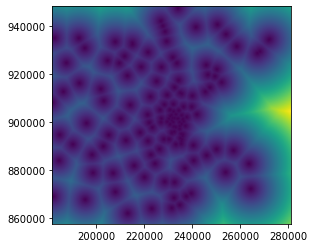

<AxesSubplot:>

In [69]:
#visualized euclidean distance

show(market_distance, transform=transform_tree)